At this stage I'm starting to focus on Object Detection task. At first we will only care about locating words.

In this notebook I'm using YOLOv3 architechure for text detection. I've chosen this algorithm mostly for its fast inference. Though I'm considering to modify it into "tiny" verion (or even simpler) for additional experiments and eventually make it more direct to the given task.

I didn't implement whole architechure myself (since I rashed to try it out).
Most of code here were copied from YoloV3 implementation of Ethan Yanjia Li (https://github.com/ethanyanjiali/deep-vision/tree/master/YOLO/tensorflow).

Here I've listed main steps that I made to make it work on DDI-100 dataset and in google colab.

- I've deleted some parts of code responsible for using multiple devices and some parts that were incompatible with google colab. 
Also changed files and folders structure to take advantage of my google drive.

- Since this model expected data in TfRecords format, I rewrote data accordingly. The author of model had a module to do that, but I had to make a lot of changes to it. Especially because my files with labels were in a different format.

- Modified preprocessing functions. Main thing was to add image slicing. Since my images are (2.7k, 2k) pixels, I couldn't just resize them into (416,416), which is what the model expects. So I sliced them into 48 overlapping (416,416) pieces. Labels were modified to fit sliced images. Plus added image preprocessing part from cv2 library.

- Trained model from zero (10 epochs took about 5 hours in colab). Results were pretty good.

# Imports

In [ ]:
import os
import argparse
import math
import datetime
import time

import tensorflow as tf
import numpy as np
import cv2

from google.colab.patches import cv2_imshow

from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)

# Create TF records with images and boxes (labels)
Writing TFrecords files on my google drive

In [ ]:
from xml.etree import ElementTree as ET
import io
import json
import pickle

In [ ]:
def parse_one_image(image_path, image_name, img_shape=[2729, 1923, 1], names_map=["text"]):
  filename = image_name
  box_path = (image_path[:-3] + "pickle").replace("gen_imgs", "gen_boxes")
  bboxes = []
  with open(box_path, "rb") as f:
    image_boxes = pickle.load(f)
    # Save only boxes for words (not for characters)
    for boxes in image_boxes:
      word_box = boxes["box"][1:3]
      bboxes.append({
              'class_text': names_map[0], 
              'class_id': 0,

              # X - width
              'xmin': word_box[0,1],
              'ymin': word_box[0,0],
              'xmax': word_box[1,1],
              'ymax': word_box[1,0],
          })

  return {
        'filepath': image_path,
        'filename': filename,
        'width': img_shape[1],
        'height': img_shape[0],
        'depth': img_shape[2],
        'bboxes': bboxes,
    }

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def genreate_tfexample(anno):
    with open(anno['filepath'], 'rb') as image_file:
        content = image_file.read()
    width = anno['width']
    height = anno['height']
    depth = anno['depth']
    if depth != 1:
        print('WANRNING: Image {} has depth of {}'.format(
            anno['filename'], depth))
    class_ids = []
    class_texts = []
    bbox_xmins = []
    bbox_ymins = []
    bbox_xmaxs = []
    bbox_ymaxs = []

    for bbox in anno['bboxes']:
        class_ids.append(bbox['class_id'])
        class_texts.append(bbox['class_text'].encode())
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox[
            'xmax'], bbox['ymax']
        bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = float(
            xmin) / width, float(ymin) / height, float(xmax) / width, float(
                ymax) / height
        
        
        if not ((bbox_xmin <= 1 and bbox_xmin >= 0) and (bbox_ymin <= 1 and bbox_ymin >= 0)
        and (bbox_xmax <= 1 and bbox_xmax >= 0) and (bbox_ymax <= 1 and bbox_ymax >= 0)):
          print("Normalization error {}".format(anno['filepath']))
          return

        bbox_xmins.append(bbox_xmin)
        bbox_ymins.append(bbox_ymin)
        bbox_xmaxs.append(bbox_xmax)
        bbox_ymaxs.append(bbox_ymax)

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/bbox/xmin':
        tf.train.Feature(float_list=tf.train.FloatList(value=bbox_xmins)),
        'image/object/bbox/ymin':
        tf.train.Feature(float_list=tf.train.FloatList(value=bbox_ymins)),
        'image/object/bbox/xmax':
        tf.train.Feature(float_list=tf.train.FloatList(value=bbox_xmaxs)),
        'image/object/bbox/ymax':
        tf.train.Feature(float_list=tf.train.FloatList(value=bbox_ymaxs)),
        'image/object/class/label':
        tf.train.Feature(int64_list=tf.train.Int64List(value=class_ids)),
        'image/object/class/text':
        tf.train.Feature(bytes_list=tf.train.BytesList(value=class_texts)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(anno['filename'].encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))



def build_single_tfrecord(anno, path):

    path = "/content/drive/My Drive/DocumentProcessing/YoloV3" + path
    with tf.io.TFRecordWriter(path) as writer:
      tf_example = genreate_tfexample(anno)
      if tf_example is not None:
        writer.write(tf_example.SerializeToString())



def build_tf_records(annotations, split):
    features = [build_single_tfrecord(anno, 
                                      '/tfrecords_voc/{}_{}.tfrecords'.format(
                                      split,
                                      str(i + 1).zfill(4))) 
                  for i, anno in enumerate(annotations)]
    return features

In [ ]:
project_folder = "/content/drive/My Drive/DocumentProcessing/YoloV3"
tf_records_folder = os.path.join(project_folder, 'tfrecords_voc')

data_path = "/content/drive/My Drive/DocumentProcessing/DDI_data/01/"
gen_data_path = data_path + "gen_imgs/"


print('Start to parse annotations.')
if not os.path.exists(tf_records_folder):
  os.makedirs(tf_records_folder)

image_annotations = []

for img_name in os.listdir(gen_data_path):
  image_id = img_name[:-4]
  # Create single example dictionary
  image_annotations.append(parse_one_image(gen_data_path + img_name, image_id))

# Splitting data
NUM_IMAGES = len(image_annotations)
train_split = int(NUM_IMAGES * 0.7)
test_split = train_split + (NUM_IMAGES - train_split) // 2

train_annotations = image_annotations[:train_split]
val_annotations = image_annotations[train_split: test_split]
test_annotations = image_annotations[test_split:]


print('Successfully parsed {} annotations.'.format(
    len(train_annotations) + len(val_annotations) + len(test_annotations)))

Start to parse annotations.
Successfully parsed 1620 annotations.


In [ ]:
print('Start to build TF Records.')
build_tf_records(train_annotations, 'train')
build_tf_records(val_annotations, 'val')
build_tf_records(test_annotations, 'test')

# Utils

In [ ]:
PROJECT_FOLDER = '/content/drive/My Drive/DocumentProcessing/YoloV3/'

def xywh_to_x1x2y1y2(box):
    xy = box[..., 0:2]
    wh = box[..., 2:4]

    x1y1 = xy - wh / 2
    x2y2 = xy + wh / 2

    y_box = tf.concat([x1y1, x2y2], axis=-1)
    return y_box


def xywh_to_y1x1y2x2(box):
    x = box[..., 0:1]
    y = box[..., 1:2]
    w = box[..., 2:3]
    h = box[..., 3:4]

    yx = tf.concat([y, x], axis=-1)
    hw = tf.concat([h, w], axis=-1)

    y1x1 = yx - hw / 2
    y2x2 = yx + hw / 2

    y_box = tf.concat([y1x1, y2x2], axis=-1)
    return y_box


def broadcast_iou(box_a, box_b):
    """
    calculate iou between box_a and multiple box_b in a broadcast way.
    Used this implementation as reference: 
    https://github.com/dmlc/gluon-cv/blob/c3dd20d4b1c1ef8b7d381ad2a7d04a68c5fa1221/gluoncv/nn/bbox.py#L206
    inputs:
    box_a: a tensor full of boxes, eg. (B, N, 4), box is in x1y1x2y2
    box_b: another tensor full of boxes, eg. (B, M, 4)
    """

    # (B, N, 1, 4)
    box_a = tf.expand_dims(box_a, -2)
    # (B, 1, M, 4)
    box_b = tf.expand_dims(box_b, -3)
    # (B, N, M, 4)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_a), tf.shape(box_b))

    # (B, N, M, 4)
    # (B, N, M, 4)
    box_a = tf.broadcast_to(box_a, new_shape)
    box_b = tf.broadcast_to(box_b, new_shape)

    # (B, N, M, 1)
    al, at, ar, ab = tf.split(box_a, 4, -1)
    bl, bt, br, bb = tf.split(box_b, 4, -1)

    # (B, N, M, 1)
    left = tf.math.maximum(al, bl)
    right = tf.math.minimum(ar, br)
    top = tf.math.maximum(at, bt)
    bot = tf.math.minimum(ab, bb)

    # (B, N, M, 1)
    iw = tf.clip_by_value(right - left, 0, 1)
    ih = tf.clip_by_value(bot - top, 0, 1)
    i = iw * ih

    # (B, N, M, 1)
    area_a = (ar - al) * (ab - at)
    area_b = (br - bl) * (bb - bt)
    union = area_a + area_b - i

    # (B, N, M)
    iou = tf.squeeze(i / (union + 1e-7), axis=-1)

    return iou


def binary_cross_entropy(logits, labels):
    epsilon = 1e-7
    logits = tf.clip_by_value(logits, epsilon, 1 - epsilon)
    return -(labels * tf.math.log(logits) +
             (1 - labels) * tf.math.log(1 - logits))

# YoloV3 model
From https://github.com/ethanyanjiali/deep-vision/tree/master/YOLO/tensorflow

In [ ]:
anchors_wh = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                       [59, 119], [116, 90], [156, 198], [373, 326]],
                      np.float32) / 416


def DarknetConv(inputs, filters, kernel_size, strides, name):
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        name=name + '_conv2d',
        use_bias=False,
        # kernel_regularizer=tf.keras.regularizers.l2(0.0005)
    )(inputs)
    # YoloV2:
    # "By adding batch normalization on all of the convolutional layers in
    #  YOLO we get more than 2% improvement in mAP."
    x = BatchNormalization(name=name + '_bn')(x)
    # YoloV1:
    # "We use a linear activation function for the ﬁnal layer and all other
    #  layers use the following leaky rectiﬁed linear activation"
    x = LeakyReLU(alpha=0.1, name=name + '_leakyrelu')(x)
    return x


def DarknetResidual(inputs, filters1, filters2, name):
    shortcut = inputs
    x = DarknetConv(
        inputs, filters=filters1, kernel_size=1, strides=1, name=name + '_1x1')
    x = DarknetConv(
        x, filters=filters2, kernel_size=3, strides=1, name=name + '_3x3')
    x = Add(name=name + '_add')([shortcut, x])
    return x


def Darknet(shape=(256, 256, 3)):
    # YoloV3:
    # Table 1. Darknet-53.
    inputs = Input(shape=shape)

    x = DarknetConv(inputs, 32, kernel_size=3, strides=1, name='conv2d_0')

    x = DarknetConv(x, 64, kernel_size=3, strides=2, name='conv2d_1')
    # 1x residual blocks
    for i in range(1):
        x = DarknetResidual(x, 32, 64, 'residual_0_' + str(i))

    x = DarknetConv(x, 128, kernel_size=3, strides=2, name='conv2d_2')
    # 2x residual blocks
    for i in range(2):
        x = DarknetResidual(x, 64, 128, 'residual_1_' + str(i))

    x = DarknetConv(x, 256, kernel_size=3, strides=2, name='conv2d_3')
    # 8x residual blocks
    for i in range(8):
        x = DarknetResidual(x, 128, 256, 'residual_2_' + str(i))

    y0 = x

    x = DarknetConv(x, 512, kernel_size=3, strides=2, name='conv2d_4')
    # 8x residual blocks
    for i in range(8):
        x = DarknetResidual(x, 256, 512, 'residual_3_' + str(i))

    y1 = x

    x = DarknetConv(x, 1024, kernel_size=3, strides=2, name='conv2d_5')
    # 4x residual blocks
    for i in range(4):
        x = DarknetResidual(x, 512, 1024, 'residual_4_' + str(i))

    y2 = x

    return tf.keras.Model(inputs, (y0, y1, y2), name='darknet_53')


def YoloV3(shape=(416, 416, 3), num_classes=2, training=False):
    # YoloV3:
    # "In our experiments with COCO [10] we predict 3 boxes at each scale so
    #  the tensor is N × N × [3 ∗ (4 + 1 + 80)] for the 4 bounding box offsets,
    #  1 objectness prediction, and 80 class predictions."
    # 3 * (4 + 1 + num_classes) = 21
    final_filters = 3 * (4 + 1 + num_classes)

    inputs = Input(shape=shape)

    backbone = Darknet(shape)
    x_small, x_medium, x_large = backbone(inputs)

    # large scale detection
    # https://github.com/pjreddie/darknet/blob/61c9d02ec461e30d55762ec7669d6a1d3c356fb2/cfg/yolov3.cfg#L549-L788
    x = DarknetConv(
        x_large,
        512,
        kernel_size=1,
        strides=1,
        name='detector_scale_large_1x1_1')
    x = DarknetConv(
        x, 1024, kernel_size=3, strides=1, name='detector_scale_large_3x3_1')
    x = DarknetConv(
        x, 512, kernel_size=1, strides=1, name='detector_scale_large_1x1_2')
    x = DarknetConv(
        x, 1024, kernel_size=3, strides=1, name='detector_scale_large_3x3_2')
    x = DarknetConv(
        x, 512, kernel_size=1, strides=1, name='detector_scale_large_1x1_3')

    y_large = DarknetConv(
        x, 1024, kernel_size=3, strides=1, name='detector_scale_large_3x3_3')
    y_large = Conv2D(
        filters=final_filters,
        kernel_size=1,
        strides=1,
        padding='same',
        name='detector_scale_large_final_conv2d',
    )(y_large)

    # meidum scale detection
    # YoloV3:
    # "Next we take the feature map from 2 layers previous and upsample it by 2×. We also take a feature map from earlier
    #  in the network and merge it with our upsampled features using concatenation. This method allows us to get more
    #  meaningful semantic information from the upsampled features and ﬁner-grained information from the earlier feature map.
    #  We then add a few more convolutional layers to process this combined feature map, and eventually predict a similar
    #  tensor, although now twice the size."
    #
    # From the code, 1x1x256 -> upsampling by 2 -> 3 times (1x1x256 -> 3x3x512)
    # https://github.com/pjreddie/darknet/blob/61c9d02ec461e30d55762ec7669d6a1d3c356fb2/cfg/yolov3.cfg#L621
    x = DarknetConv(
        x, 256, kernel_size=1, strides=1, name='detector_scale_medium_1x1_0')

    # Although not explained in the paper, the upsampling mentioned by the author
    # is just interprolation as seen from here
    # https://github.com/pjreddie/darknet/blob/61c9d02ec461e30d55762ec7669d6a1d3c356fb2/src/blas.c#L334
    x = UpSampling2D(size=(2, 2), name='detector_scale_1_upsampling')(x)
    x = Concatenate(name='detector_scale_1_concat')([x, x_medium])

    x = DarknetConv(
        x, 256, kernel_size=1, strides=1, name='detector_scale_medium_1x1_1')
    x = DarknetConv(
        x, 512, kernel_size=3, strides=1, name='detector_scale_medium_3x3_1')
    x = DarknetConv(
        x, 256, kernel_size=1, strides=1, name='detector_scale_medium_1x1_2')
    x = DarknetConv(
        x, 512, kernel_size=3, strides=1, name='detector_scale_medium_3x3_2')
    x = DarknetConv(
        x, 256, kernel_size=1, strides=1, name='detector_scale_medium_1x1_3')

    y_medium = DarknetConv(
        x, 512, kernel_size=3, strides=1, name='detector_scale_medium_3x3_3')
    y_medium = Conv2D(
        filters=final_filters,
        kernel_size=1,
        strides=1,
        padding='same',
        name='detector_scale_medium_final_conv2d',
    )(y_medium)

    # small scale detection
    # YoloV3:
    # "We perform the same design one more time to predict boxes for the ﬁnal scale."
    x = DarknetConv(
        x, 128, kernel_size=1, strides=1, name='detector_scale_small_1x1_0')
    x = UpSampling2D(size=(2, 2), name='detector_scale_small_upsampling')(x)
    x = Concatenate(name='detector_scale_small_concat')([x, x_small])

    x = DarknetConv(
        x, 128, kernel_size=1, strides=1, name='detector_scale_small_1x1_1')
    x = DarknetConv(
        x, 256, kernel_size=3, strides=1, name='detector_scale_small_3x3_1')
    x = DarknetConv(
        x, 128, kernel_size=1, strides=1, name='detector_scale_small_1x1_2')
    x = DarknetConv(
        x, 256, kernel_size=3, strides=1, name='detector_scale_small_3x3_2')
    x = DarknetConv(
        x, 128, kernel_size=1, strides=1, name='detector_scale_small_1x1_3')

    y_small = DarknetConv(
        x, 256, kernel_size=3, strides=1, name='detector_scale_small_3x3_3')
    y_small = Conv2D(
        filters=final_filters,
        kernel_size=1,
        strides=1,
        padding='same',
        name='detector_scale_small_final_conv2d',
    )(y_small)

    # reshape (N, grid, grid, 21) into (N, grid, grid, 3, 7) to seprate predictions
    # for each anchor
    y_small_shape = tf.shape(y_small)
    y_medium_shape = tf.shape(y_medium)
    y_large_shape = tf.shape(y_large)

    y_small = tf.reshape(
        y_small, (y_small_shape[0], y_small_shape[1], y_small_shape[2], 3, -1),
        name='detector_reshape_small')
    y_medium = tf.reshape(
        y_medium,
        (y_medium_shape[0], y_medium_shape[1], y_medium_shape[2], 3, -1),
        name='detector_reshape_meidum')
    y_large = tf.reshape(
        y_large, (y_large_shape[0], y_large_shape[1], y_large_shape[2], 3, -1),
        name='detector_reshape_large')

    if training:
        return tf.keras.Model(inputs, (y_small, y_medium, y_large))

    box_small = Lambda(
        lambda x: get_absolute_yolo_box(x, anchors_wh[0:3], num_classes),
        name='detector_final_box_small')(y_small)
    box_medium = Lambda(
        lambda x: get_absolute_yolo_box(x, anchors_wh[3:6], num_classes),
        name='detector_final_box_medium')(y_medium)
    box_large = Lambda(
        lambda x: get_absolute_yolo_box(x, anchors_wh[6:9], num_classes),
        name='detector_final_box_large')(y_large)

    outputs = (box_small, box_medium, box_large)
    return tf.keras.Model(inputs, outputs)


def get_absolute_yolo_box(y_pred, valid_anchors_wh, num_classes):
    """
    Given a cell offset prediction from the model, calculate the absolute box coordinates to the whole image.
    It's also an adpation of the original C code here:
    https://github.com/pjreddie/darknet/blob/f6d861736038da22c9eb0739dca84003c5a5e275/src/yolo_layer.c#L83
    note that, we divide w and h by grid size 
    inputs:
    y_pred: Prediction tensor from the model output, in the shape of (batch, grid, grid, anchor, 5 + num_classes)
    outputs:
    y_box: boxes in shape of (batch, grid, grid, anchor, 4), the last dimension is (xmin, ymin, xmax, ymax)
    objectness: probability that an object exists
    classes: probability of classes
    """

    t_xy, t_wh, objectness, classes = tf.split(
        y_pred, (2, 2, 1, num_classes), axis=-1)

    objectness = tf.sigmoid(objectness)
    classes = tf.sigmoid(classes)

    grid_size = tf.shape(y_pred)[1]
    # meshgrid generates a grid that repeats by given range. It's the Cx and Cy in YoloV3 paper.
    # for example, tf.meshgrid(tf.range(3), tf.range(3)) will generate a list with two elements
    # note that in real code, the grid_size should be something like 13, 26, 52 for examples here and below
    #
    # [[0, 1, 2],
    #  [0, 1, 2],
    #  [0, 1, 2]]
    #
    # [[0, 0, 0],
    #  [1, 1, 1],
    #  [2, 2, 2]]
    #
    C_xy = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))

    # next, we stack two items in the list together in the last dimension, so that
    # we can interleve these elements together and become this:
    #
    # [[[0, 0], [1, 0], [2, 0]],
    #  [[0, 1], [1, 1], [2, 1]],
    #  [[0, 2], [1, 2], [2, 2]]]
    #
    C_xy = tf.stack(C_xy, axis=-1)

    # let's add an empty dimension at axis=2 to expand the tensor to this:
    #
    # [[[[0, 0]], [[1, 0]], [[2, 0]]],
    #  [[[0, 1]], [[1, 1]], [[2, 1]]],
    #  [[[0, 2]], [[1, 2]], [[2, 2]]]]
    #
    # at this moment, we now have a grid, which can always give us (y, x)
    # if we access grid[x][y]. For example, grid[0][1] == [[1, 0]]
    C_xy = tf.expand_dims(C_xy, axis=2)  # [gx, gy, 1, 2]

    # YoloV2, YoloV3:
    # bx = sigmoid(tx) + Cx
    # by = sigmoid(ty) + Cy
    #
    # for example, if all elements in b_xy are (0.1, 0.2), the result will be
    #
    # [[[[0.1, 0.2]], [[1.1, 0.2]], [[2.1, 0.2]]],
    #  [[[0.1, 1.2]], [[1.1, 1.2]], [[2.1, 1.2]]],
    #  [[[0.1, 2.2]], [[1.1, 2.2]], [[2.1, 2.2]]]]
    #
    b_xy = tf.sigmoid(t_xy) + tf.cast(C_xy, tf.float32)

    # finally, divide this absolute box_xy by grid_size, and then we will get the normalized bbox centroids
    # for each anchor in each grid cell. b_xy is now in shape (batch_size, grid_size, grid_size, num_anchor, 2)
    #
    # [[[[0.1/3, 0.2/3]], [[1.1/3, 0.2/3]], [[2.1/3, 0.2/3]]],
    #  [[[0.1/3, 1.2/3]], [[1.1/3, 1.2]/3], [[2.1/3, 1.2/3]]],
    #  [[[0.1/3, 2.2/3]], [[1.1/3, 2.2/3]], [[2.1/3, 2.2/3]]]]
    #
    b_xy = b_xy / tf.cast(grid_size, tf.float32)

    # YoloV2:
    # "If the cell is offset from the top left corner of the image by (cx , cy)
    # and the bounding box prior has width and height pw , ph , then the predictions correspond to: "
    #
    # https://github.com/pjreddie/darknet/issues/568#issuecomment-469600294
    # "It’s OK for the predicted box to be wider and/or taller than the original image, but
    # it does not make sense for the box to have a negative width or height. That’s why
    # we take the exponent of the predicted number."
    b_wh = tf.exp(t_wh) * valid_anchors_wh

    y_box = tf.concat([b_xy, b_wh], axis=-1)
    return y_box, objectness, classes


def get_relative_yolo_box(y_true, valid_anchors_wh):
    """
    This is the inverse of `get_absolute_yolo_box` above. It's turning (bx, by, bw, bh) into
    (tx, ty, tw, th) that is relative to cell location.
    """
    grid_size = tf.shape(y_true)[1]
    C_xy = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    C_xy = tf.expand_dims(tf.stack(C_xy, axis=-1), axis=2)

    b_xy = y_true[..., 0:2]
    b_wh = y_true[..., 2:4]
    t_xy = b_xy * tf.cast(grid_size, tf.float32) - tf.cast(C_xy, tf.float32)

    t_wh = tf.math.log(b_wh / valid_anchors_wh)
    # b_wh could have some cells are 0, divided by anchor could result in inf or nan
    t_wh = tf.where(
        tf.logical_or(tf.math.is_inf(t_wh), tf.math.is_nan(t_wh)),
        tf.zeros_like(t_wh), t_wh)

    y_box = tf.concat([t_xy, t_wh], axis=-1)
    return y_box


class YoloLoss(object):
    def __init__(self, num_classes, valid_anchors_wh):
        self.num_classes = num_classes
        self.ignore_thresh = 0.5
        self.valid_anchors_wh = valid_anchors_wh
        self.lambda_coord = 5.0
        self.lamda_noobj = 0.5

    def __call__(self, y_true, y_pred):
        """
        calculate the loss of model prediction for one scale
        """
        # for xy and wh, I seperated them into two groups with different suffix
        # suffix rel (relative) means that its coordinates are relative to cells
        # basically (tx, ty, tw, th) format from the paper
        # _rel is used to calcuate the loss
        # suffix abs (absolute) means that its coordinates are absolute with in whole image
        # basically (bx, by, bw, bh) format from the paper
        # _abs is used to calcuate iou and ignore mask

        # split y_pred into xy, wh, objectness and one-hot classes
        # pred_xy_rel: (batch, grid, grid, anchor, 2)
        # pred_wh_rel: (batch, grid, grid, anchor, 2)
        # TODO: Add comment for the sigmoid here
        pred_xy_rel = tf.sigmoid(y_pred[..., 0:2])
        pred_wh_rel = y_pred[..., 2:4]

        # this box is used to calculate iou, NOT loss. so we can't use
        # cell offset anymore and have to transform it into true values
        # both pred_obj and pred_class has been sigmoid'ed here
        # pred_xy_abs: (batch, grid, grid, anchor, 2)
        # pred_wh_abs: (batch, grid, grid, anchor, 2)
        # pred_obj: (batch, grid, grid, anchor, 1)
        # pred_class: (batch, grid, grid, anchor, num_classes)
        pred_box_abs, pred_obj, pred_class = get_absolute_yolo_box(
            y_pred, self.valid_anchors_wh, self.num_classes)
        pred_box_abs = xywh_to_x1x2y1y2(pred_box_abs)

        # split y_true into xy, wh, objectness and one-hot classes
        # pred_xy_abs: (batch, grid, grid, anchor, 2)
        # pred_wh_abs: (batch, grid, grid, anchor, 2)
        # pred_obj: (batch, grid, grid, anchor, 1)
        # pred_class: (batch, grid, grid, anchor, num_classes)
        true_xy_abs, true_wh_abs, true_obj, true_class = tf.split(
            y_true, (2, 2, 1, self.num_classes), axis=-1)
        true_box_abs = tf.concat([true_xy_abs, true_wh_abs], axis=-1)
        true_box_abs = xywh_to_x1x2y1y2(true_box_abs)

        # true_box_rel: (batch, grid, grid, anchor, 4)
        true_box_rel = get_relative_yolo_box(y_true, self.valid_anchors_wh)
        true_xy_rel = true_box_rel[..., 0:2]
        true_wh_rel = true_box_rel[..., 2:4]

        # some adjustment to improve small box detection, note the (2-truth.w*truth.h) below
        # https://github.com/pjreddie/darknet/blob/f6d861736038da22c9eb0739dca84003c5a5e275/src/yolo_layer.c#L190
        weight = 2 - true_wh_abs[..., 0] * true_wh_abs[..., 1]

        # YoloV2:
        # "If the cell is offset from the top left corner of the image by (cx , cy)
        # and the bounding box prior has width and height pw , ph , then the predictions correspond to:"
        #
        # to calculate the iou and determine the ignore mask, we need to first transform
        # prediction into real coordinates (bx, by, bw, bh)

        # YoloV2:
        # "This ground truth value can be easily computed by inverting the equations above."
        #
        # to calculate loss and differentiation, we need to transform ground truth into
        # cell offset first like demonstrated here:
        # https://github.com/pjreddie/darknet/blob/f6d861736038da22c9eb0739dca84003c5a5e275/src/yolo_layer.c#L93
        xy_loss = self.calc_xy_loss(true_obj, true_xy_rel, pred_xy_rel, weight)
        wh_loss = self.calc_wh_loss(true_obj, true_wh_rel, pred_wh_rel, weight)
        class_loss = self.calc_class_loss(true_obj, true_class, pred_class)

        # use the absolute yolo box to calculate iou and ignore mask
        ignore_mask = self.calc_ignore_mask(true_obj, true_box_abs,
                                            pred_box_abs)
        obj_loss = self.calc_obj_loss(true_obj, pred_obj, ignore_mask)

        # YoloV1: Function (3)
        return xy_loss + wh_loss + class_loss + obj_loss, (xy_loss, wh_loss,
                                                           class_loss,
                                                           obj_loss)

    def calc_ignore_mask(self, true_obj, true_box, pred_box):
        # YOLOv3:
        # "If the bounding box prior is not the best but does overlap a ground
        # truth object by more than some threshold we ignore the prediction,
        # following [17]. We use the threshold of .5."
        # calculate the iou for each pair of pred bbox and true bbox, then find the best among them

        # (None, 13, 13, 3, 4)
        true_box_shape = tf.shape(true_box)
        # (None, 13, 13, 3, 4)
        pred_box_shape = tf.shape(pred_box)
        # (None, 507, 4)
        true_box = tf.reshape(true_box, [true_box_shape[0], -1, 4])
        # sort true_box to have non-zero boxes rank first
        true_box = tf.sort(true_box, axis=1, direction="DESCENDING")
        # (None, 100, 4)
        # only use maximum 100 boxes per groundtruth to calcualte IOU, otherwise
        # GPU emory comsumption would explode for a matrix like (16, 52*52*3, 52*52*3, 4)
        true_box = true_box[:, 0:100, :]
        # (None, 507, 4)
        pred_box = tf.reshape(pred_box, [pred_box_shape[0], -1, 4])

        # https://github.com/dmlc/gluon-cv/blob/06bb7ec2044cdf3f433721be9362ab84b02c5a90/gluoncv/model_zoo/yolo/yolo_target.py#L198
        # (None, 507, 507)
        iou = broadcast_iou(pred_box, true_box)
        # (None, 507)
        best_iou = tf.reduce_max(iou, axis=-1)
        # (None, 13, 13, 3)
        best_iou = tf.reshape(best_iou, [pred_box_shape[0], pred_box_shape[1], pred_box_shape[2], pred_box_shape[3]])
        # ignore_mask = 1 => don't ignore
        # ignore_mask = 0 => should ignore
        ignore_mask = tf.cast(best_iou < self.ignore_thresh, tf.float32)
        # (None, 13, 13, 3, 1)
        ignore_mask = tf.expand_dims(ignore_mask, axis=-1)
        return ignore_mask

    def calc_obj_loss(self, true_obj, pred_obj, ignore_mask):
        """
        calculate loss of objectness: sum of L2 distances
        inputs:
        true_obj: objectness from ground truth in shape of (batch, grid, grid, anchor, num_classes)
        pred_obj: objectness from model prediction in shape of (batch, grid, grid, anchor, num_classes)
        outputs:
        obj_loss: objectness loss
        """
        obj_entropy = binary_cross_entropy(pred_obj, true_obj)

        obj_loss = true_obj * obj_entropy
        noobj_loss = (1 - true_obj) * obj_entropy * ignore_mask

        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3, 4))
        noobj_loss = tf.reduce_sum(
            noobj_loss, axis=(1, 2, 3, 4)) * self.lamda_noobj

        return obj_loss + noobj_loss

    def calc_class_loss(self, true_obj, true_class, pred_class):
        """
        calculate loss of class prediction
        inputs:
        true_obj: if the object present from ground truth in shape of (batch, grid, grid, anchor, 1)
        true_class: one-hot class from ground truth in shape of (batch, grid, grid, anchor, num_classes)
        pred_class: one-hot class from model prediction in shape of (batch, grid, grid, anchor, num_classes)
        outputs:
        class_loss: class loss
        """
        # Yolov1:
        # "Note that the loss function only penalizes classiﬁcation error
        # if an object is present in that grid cell (hence the conditional
        # class probability discussed earlier).
        class_loss = binary_cross_entropy(pred_class, true_class)
        class_loss = true_obj * class_loss
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3, 4))
        return class_loss

    def calc_xy_loss(self, true_obj, true_xy, pred_xy, weight):
        """
        calculate loss of the centroid coordinate: sum of L2 distances
        inputs:
        true_obj: if the object present from ground truth in shape of (batch, grid, grid, anchor, 1)
        true_xy: centroid x and y from ground truth in shape of (batch, grid, grid, anchor, 2)
        pred_xy: centroid x and y from model prediction in shape of (batch, grid, grid, anchor, 2)
        weight: weight adjustment, reward smaller bounding box
        outputs:
        xy_loss: centroid loss
        """
        # shape (batch, grid, grid, anchor), eg. (32, 13, 13, 3)
        xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)

        # in order to element-wise multiply the result from tf.reduce_sum
        # we need to squeeze one dimension for objectness here
        true_obj = tf.squeeze(true_obj, axis=-1)

        # YoloV1:
        # "It also only penalizes bounding box coordinate error if that
        # predictor is "responsible" for the ground truth box (i.e. has the
        # highest IOU of any predictor in that grid cell)."
        xy_loss = true_obj * xy_loss * weight

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3)) * self.lambda_coord

        return xy_loss

    def calc_wh_loss(self, true_obj, true_wh, pred_wh, weight):
        """
        calculate loss of the width and height: sum of L2 distances
        inputs:
        true_obj: if the object present from ground truth in shape of (batch, grid, grid, anchor, 1)
        true_wh: width and height from ground truth in shape of (batch, grid, grid, anchor, 2)
        pred_wh: width and height from model prediction in shape of (batch, grid, grid, anchor, 2)
        weight: weight adjustment, reward smaller bounding box
        outputs:
        wh_loss: width and height loss
        """
        # shape (batch, grid, grid, anchor), eg. (32, 13, 13, 3)
        wh_loss = tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        true_obj = tf.squeeze(true_obj, axis=-1)
        wh_loss = true_obj * wh_loss * weight
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3)) * self.lambda_coord
        return wh_loss

# Preprocessor class
Plus some labels visualisation utilities

## Class

In [ ]:
def cv2_background_clearing(image_encoded):
    """
    Function to take advantage of cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    Takes tensor with bytes image
    Returns tensor with image of shape (x,y,1)
    """

    image = cv2.imdecode(np.frombuffer(image_encoded.numpy(), np.uint8), 0)

    segmented = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15)
    image = tf.where(segmented == 255, segmented, image)

    image = tf.expand_dims(image, axis=-1)
    image.set_shape([2729, 1923, 1])
    image = tf.cast(image, tf.float32)
    return image

class Preprocessor(object):
    def __init__(self, is_train, num_classes, output_shape=(416, 416), add_outputs=False):
        self.is_train = is_train
        self.num_classes = num_classes
        self.output_shape = output_shape
        self.additional_outputs = add_outputs
    
    def __call__(self, example):
        features = self.parse_tfexample(example)

        encoded = features['image/encoded']


        or_image = tf.py_function(cv2_background_clearing, 
                                        inp=[encoded],
                                        Tout=tf.float32)
        #or_image = tf.io.decode_jpeg(encoded)
        #or_image = tf.cast(or_image, tf.float32)

        classes, bboxes = self.parse_y_features(features)

        
        # Cutting image
        n_images=(8,6)
        kernel_size = self.output_shape
        image_size=(2729, 1923)
        steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
        eps = tf.keras.backend.epsilon()

        slices = tf.image.extract_patches(tf.expand_dims(or_image, axis=0), # adding batch axis
                    sizes=[1,kernel_size[0], kernel_size[1],1], 
                    strides=[1, steps[0], steps[1], 1], 
                    rates=[1,1,1,1], 
                    padding="VALID")

        sliced_images = tf.reshape(slices, (-1, kernel_size[0], kernel_size[1], 1))
        images = sliced_images / 127.5 - 1
        
        images = tf.ensure_shape(images, (48,416,416,1))

        # Cutting labels

        labels_52, labels_26, labels_13 = [], [], []
        if self.additional_outputs:
          boxes_norm_all = [] 

        for i in range(n_images[0]):
          for j in range(n_images[1]):
            
            # Relative location of sliced image
            im_rloc = [j * steps[1] / image_size[1], 
                      i * steps[0] / image_size[0],
                      (j * steps[1] + kernel_size[1]) / image_size[1],
                      (i * steps[0] + kernel_size[0]) / image_size[0]]

            # Get 4 points locations
            ul_pts = bboxes[:,0:2]
            lr_pts = bboxes[:,2:4]
            ll_pts = tf.concat([bboxes[:,0:1], bboxes[:,3:4]], axis=1)
            ur_pts = tf.concat([bboxes[:,2:3], bboxes[:,1:2]], axis=1)
            
            # Corners of image
            ul = tf.constant([im_rloc[0], im_rloc[1]])  # upper-left  x1,y1
            lr = tf.constant([im_rloc[2], im_rloc[3]])  # lower-right x2,y2

            # Logical operations if point in the image
            in_pts = []
            for pts in [ul_pts, lr_pts, ll_pts, ur_pts]:
              in_pts.append(tf.math.reduce_all(tf.math.logical_and(ul <= pts, 
                                                              ul_pts <= lr), axis=1))

            in_ul_lr = tf.math.logical_or(in_pts[0], in_pts[1])
            in_ll_ur = tf.math.logical_or(in_pts[2], in_pts[3])
            in_all = tf.math.logical_or(in_ul_lr, in_ll_ur)
            inbox = bboxes[in_all]

            if tf.equal(tf.size(inbox), 0):
              bboxes_norm = tf.constant([[0.47,0.47,0.52,0.52]], dtype=tf.float32)
              classes1 = tf.constant([0,1], dtype=tf.float32, shape=(1,2))
           
            else:
               # Normalization and clipping to the image edges
              min_values = tf.constant([im_rloc[0], im_rloc[1]] * 2, dtype=tf.float32)
              max_values = tf.constant([im_rloc[2], im_rloc[3]] * 2, dtype=tf.float32)
              bboxes_norm = (inbox - min_values) / (max_values - min_values)
              bboxes_norm = tf.clip_by_value(bboxes_norm, 0+eps, 1-eps)
              classes1 = classes[:len(bboxes_norm)]

            label_52 = self.preprocess_label_for_one_scale(classes1, bboxes_norm, 52,
                                               np.array([0, 1, 2]))
            label_26 = self.preprocess_label_for_one_scale(classes1, bboxes_norm, 26,
                                               np.array([3, 4, 5]))
            label_13 = self.preprocess_label_for_one_scale(classes1, bboxes_norm, 13,
                                               np.array([6, 7, 8]))
            labels_52.append(label_52)
            labels_26.append(label_26)
            labels_13.append(label_13)
            
            if self.additional_outputs:
              # Returning boxes to check if their transformations were correct
              ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
              ta = ta.unstack(bboxes_norm)
              c1 = ta.size()
              while ta.size() < 50:
                ta = ta.write(c1+1, [0,0,0,0])
                c1 += 1
              bboxes_norm = ta.stack()   
              boxes_norm_all.append(bboxes_norm)

        if self.additional_outputs:
          return images, labels_52, labels_26, labels_13, boxes_norm_all, bboxes, encoded
        else:
          return images, labels_52, labels_26, labels_13
    

    def parse_y_features(self, features):
        classes = tf.sparse.to_dense(features['image/object/class/label'])
        classes = tf.one_hot(classes, self.num_classes)
 
        # bboxes shape (None, 4)
        bboxes = tf.stack([
            tf.sparse.to_dense(features['image/object/bbox/xmin']),
            tf.sparse.to_dense(features['image/object/bbox/ymin']),
            tf.sparse.to_dense(features['image/object/bbox/xmax']),
            tf.sparse.to_dense(features['image/object/bbox/ymax']),
        ],
                          axis=1)
        return classes, bboxes

    def preprocess_label_for_one_scale(self,
                                       classes,
                                       bboxes,
                                       grid_size=13,
                                       valid_anchors=None):
        """
        preprocess the class and bounding boxes annotations into model desired format for one scale
        (grid, grid, anchor, (centroid x, centroid y, width, height, objectness, ...one-hot classes...))
        inputs:
        grid_size: a scalar grid size to use
        outputs:
        y: the desired label format to calcualte loss
        """
        # construct an empty placeholder for the final output y first
        y = tf.zeros((grid_size, grid_size, 3, 5 + self.num_classes))

        # find the best anchor indices for each ground truth box
        anchor_indices = self.find_best_anchor(bboxes)

        # necessary assertion, otherwise the steps later would fail

        tf.Assert(classes.shape[0] == bboxes.shape[0], [classes])
        tf.Assert(anchor_indices.shape[0] == bboxes.shape[0], [anchor_indices])

        # this has to be tf.shape instead of classes.shape, otherwise would be None
        num_boxes = tf.shape(classes)[0]

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        valid_count = 0
        for i in tf.range(num_boxes):
            curr_class = tf.cast(classes[i], tf.float32)
            curr_box = bboxes[i]
            curr_anchor = anchor_indices[i]

            # only use the anchor when it belongs to current scale (grid_size)
            # for example, when grid size is 13, only anchor 6, 7, 8 (big anchors) are valid
            # because the reception field of this grid size is the biggest
            # however, if grid size is 52, the finest grained grid, we can only use anchor
            # 0, 1, 2 (small anchors)
            anchor_found = tf.reduce_any(curr_anchor == valid_anchors)
            if anchor_found:
                # now that we found the anchor, we need to set it in our final output y
                # we only have three anchor boxes in y, so we need to mod by 3 first to get
                # adjusted index. eg. anchor 7 will have index 1
                # we need to reshape here so that adjusted_anchor_index is a vector
                adjusted_anchor_index = tf.math.floormod(curr_anchor, 3)

                # we need to turn (xmin, ymin, xmax, ymax) box format into
                # (centeroid x, centroid y, width, height) to be able to
                # calculate yolo loss later
                curr_box_xy = (curr_box[..., 0:2] + curr_box[..., 2:4]) / 2
                curr_box_wh = curr_box[..., 2:4] - curr_box[..., 0:2]

                # calculate which grid cell should we use
                # eg. when curr_box_xy = [0.25, 0.25], and grid size = 26, which is a quarter of the image
                # the index of grid cell is floor(0.25 * 26) = 6
                grid_cell_xy = tf.cast(
                    curr_box_xy // tf.cast((1 / grid_size), dtype=tf.float32),
                    tf.int32)

                # for this box, we need to update y at location (grid_size, grid_size, adjusted_anchor_index)
                # eg. shape in (13, 13, 1)
                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                # note that it's not grid[x][y]
                index = tf.stack(
                    [grid_cell_xy[1], grid_cell_xy[0], adjusted_anchor_index])

                # this is the value we use to update the above location
                # eg. shape in (7)
                # note that we need to make this one-hot classes in order to use categorical crossentropy later
                update = tf.concat(
                    values=[
                        curr_box_xy, curr_box_wh,
                        tf.constant([1.0]), curr_class
                    ],
                    axis=0)
                # add to final indices and updates to be written into y
                indices = indices.write(valid_count, index)
                updates = updates.write(valid_count, update)
                valid_count = 1 + valid_count

        y = tf.tensor_scatter_nd_update(y, indices.stack(), updates.stack())
        return y

    def find_best_anchor(self, y_box):
        """
        find the best anchor for num_boxes ground truth boxes in y_box. Return a tensor in shape
        of (num_boxes) that indicates the indices of best anchor for each box
        inputs:
        y_box: ground truth boxes in shape of (num_boxes, 4)
        outputs:
        anchor_idx: anchor indices in shape of (num_boxes)
        """
        box_wh = y_box[..., 2:4] - y_box[..., 0:2]

        # since box_wh is (num_boxes, 2) and anchor_wh is (9, 2), we need to tile box_wh
        # first to match number to anchor in order to apply tf.minimum later
        # eg. box_wh -> (2, 9, 2)
        box_wh = tf.tile(
            tf.expand_dims(box_wh, -2), (1, tf.shape(anchors_wh)[0], 1))

        # the intersection here is not calculated based on real coordinates
        # but assuming anchor and box share same centroid to help us decide
        # which is the best fit anchor for this box
        # so we just take the product of minimum width and height as intersection
        # eg. intersection -> (2, 9)
        intersection = tf.minimum(box_wh[..., 0],
                                  anchors_wh[..., 0]) * tf.minimum(
                                      box_wh[..., 1], anchors_wh[..., 1])

        # box_area is the width*height for each box
        # eg box_area -> (2, 9)
        box_area = box_wh[..., 0] * box_wh[..., 1]

        # anchor area is the width*height for each anchor
        # eg anchor_area -> (9)
        anchor_area = anchors_wh[..., 0] * anchors_wh[..., 1]

        # eg. iou -> (2, 9)
        iou = intersection / (box_area + anchor_area - intersection)

        # find the best anchor for each box, there should be num_boxes indices
        # in the result
        # eg. anchor_idx -> (2)
        anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.int32)
        return anchor_idx

    def parse_tfexample(self, example_proto):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example_proto,
                                          image_feature_description)
        

## Data loads (For preprocessing experiments)

In [ ]:
tfrecords = PROJECT_FOLDER + 'tfrecords_voc'
TOTAL_CLASSES= 2
OUTPUT_SHAPE = (416,416)
# Note - for additional outputs (original and sliced boxes) don't unbatch
preprocess = Preprocessor(True, TOTAL_CLASSES, OUTPUT_SHAPE, add_outputs=False)

dataset = tf.data.Dataset.list_files('{}/train*'.format(tfrecords))
dataset = tf.data.TFRecordDataset(dataset)

dataset = dataset.map(preprocess).unbatch()

# Note - for additional outputs add y4,y5
tupling_label = lambda x,y1,y2,y3: (x, (y1,y2,y3)) 
dataset = dataset.map(tupling_label)

dataset = dataset.batch(16)

dataset = dataset.prefetch(1)

<unknown>


In [ ]:
ex, label = next(iter(dataset))

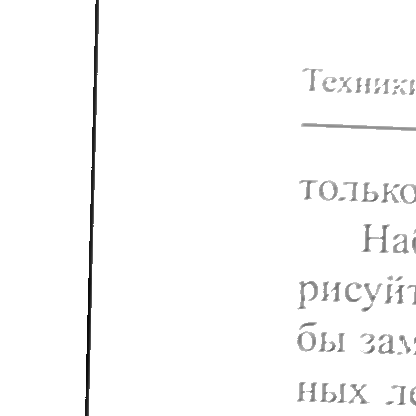

In [ ]:
cv2_imshow((ex[0].numpy().squeeze() + 1 ) * 127.5)

## Slicing boxes experiments

### Numpy

In [ ]:
n_images=(8,6)
kernel_size = (416,416)
image_size=(2729, 1923)
steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]

#xmin, ymin, xmax, ymax
bboxes = label[4].numpy()

boxes_norm_all = []
im_rlocs = []
for i in range(8):
  for j in range(6):
    #print(i,j)
    im_rloc = [j * steps[1] / image_size[1], 
              i * steps[0] / image_size[0],
              (j * steps[1] + kernel_size[1]) / image_size[1],
              (i * steps[0] + kernel_size[0]) / image_size[0]]
    im_rlocs.append(im_rloc)

    min_pts = bboxes[:,0:2]
    max_pts = bboxes[:,2:4]
    ll_pts = np.c_[bboxes[:,0], bboxes[:,3]]
    ur_pts = np.c_[bboxes[:,2], bboxes[:,1]]

    ul = np.array([im_rloc[0], im_rloc[1]])  # upper-left  x1,y1
    lr = np.array([im_rloc[2], im_rloc[3]])  # lower-right x2,y2
    #ll = np.array()                          # lower-left

    in_min = np.all(np.logical_and(ul <= min_pts, min_pts <= lr), axis=1)
    in_max = np.all(np.logical_and(ul <= max_pts, max_pts <= lr), axis=1)
    in_ll = np.all(np.logical_and(ul <= ll_pts, ll_pts <= lr), axis=1)
    in_ur = np.all(np.logical_and(ul <= ur_pts, ur_pts <= lr), axis=1)
    in_min_max = np.logical_or(in_min, in_max)
    in_ll_ur = np.logical_or(in_ll, in_ur)
    in_all = np.logical_or(in_min_max, in_ll_ur)
    inbox = bboxes[in_all]

    # Normalization
    min_values = tf.constant([im_rloc[0], im_rloc[1]] * 2)
    max_values = tf.constant([im_rloc[2], im_rloc[3]] * 2)
    bboxes_norm = (inbox - min_values) / (max_values - min_values)

    bboxes_norm = tf.clip_by_value(bboxes_norm, 0.00001, 0.99999)

    boxes_norm_all.append(bboxes_norm)
    #print(im_rloc)

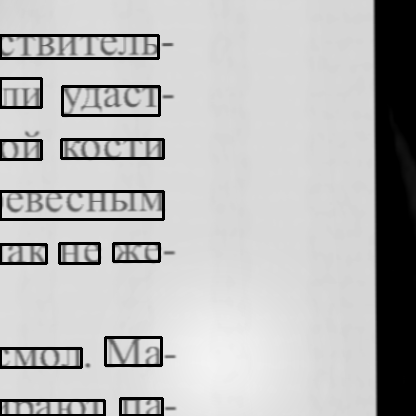

In [ ]:
show_unprocessed_sliced_boxes(ex[27], boxes_norm_all[27].numpy())

### Converting to tf

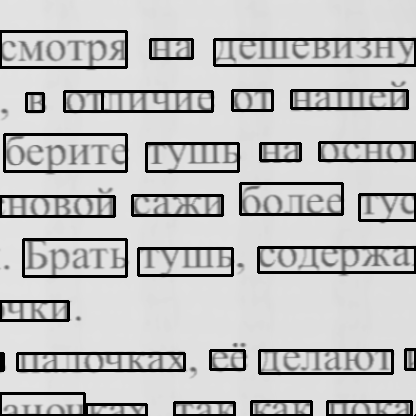

In [ ]:
n_images=(8,6)
kernel_size = (416,416)
image_size=(2729, 1923)
steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
eps = tf.keras.backend.epsilon()

#xmin, ymin, xmax, ymax
bboxes = label[4]
boxes_norm_all = []

for i in range(n_images[0]):
  for j in range(n_images[1]):
    
    # Relative location of sliced image
    im_rloc = [j * steps[1] / image_size[1], 
              i * steps[0] / image_size[0],
              (j * steps[1] + kernel_size[1]) / image_size[1],
              (i * steps[0] + kernel_size[0]) / image_size[0]]

    # Get 4 points locations
    ul_pts = bboxes[:,0:2]
    lr_pts = bboxes[:,2:4]
    ll_pts = tf.concat([bboxes[:,0:1], bboxes[:,3:4]], axis=1)
    ur_pts = tf.concat([bboxes[:,2:3], bboxes[:,1:2]], axis=1)
    
    # Corners of image
    ul = tf.constant([im_rloc[0], im_rloc[1]])  # upper-left  x1,y1
    lr = tf.constant([im_rloc[2], im_rloc[3]])  # lower-right x2,y2

    # Logical operations if point in the image
    in_pts = []
    for pts in [ul_pts, lr_pts, ll_pts, ur_pts]:
      in_pts.append(tf.math.reduce_all(tf.math.logical_and(ul <= pts, 
                                                      ul_pts <= lr), axis=1))
    
    in_ul_lr = tf.math.logical_or(in_pts[0], in_pts[1])
    in_ll_ur = tf.math.logical_or(in_pts[2], in_pts[3])
    in_all = tf.math.logical_or(in_min_max, in_ll_ur)
    inbox = bboxes[in_all]

    # Normalization and clipping to the image edges
    min_values = tf.constant([im_rloc[0], im_rloc[1]] * 2)
    max_values = tf.constant([im_rloc[2], im_rloc[3]] * 2)
    bboxes_norm = (inbox - min_values) / (max_values - min_values)
    bboxes_norm = tf.clip_by_value(bboxes_norm, 0+eps, 1-eps)
    boxes_norm_all.append(bboxes_norm)

show_unprocessed_sliced_boxes(ex[27], boxes_norm_all[27].numpy())

## Recovering full image (from 48 slices)

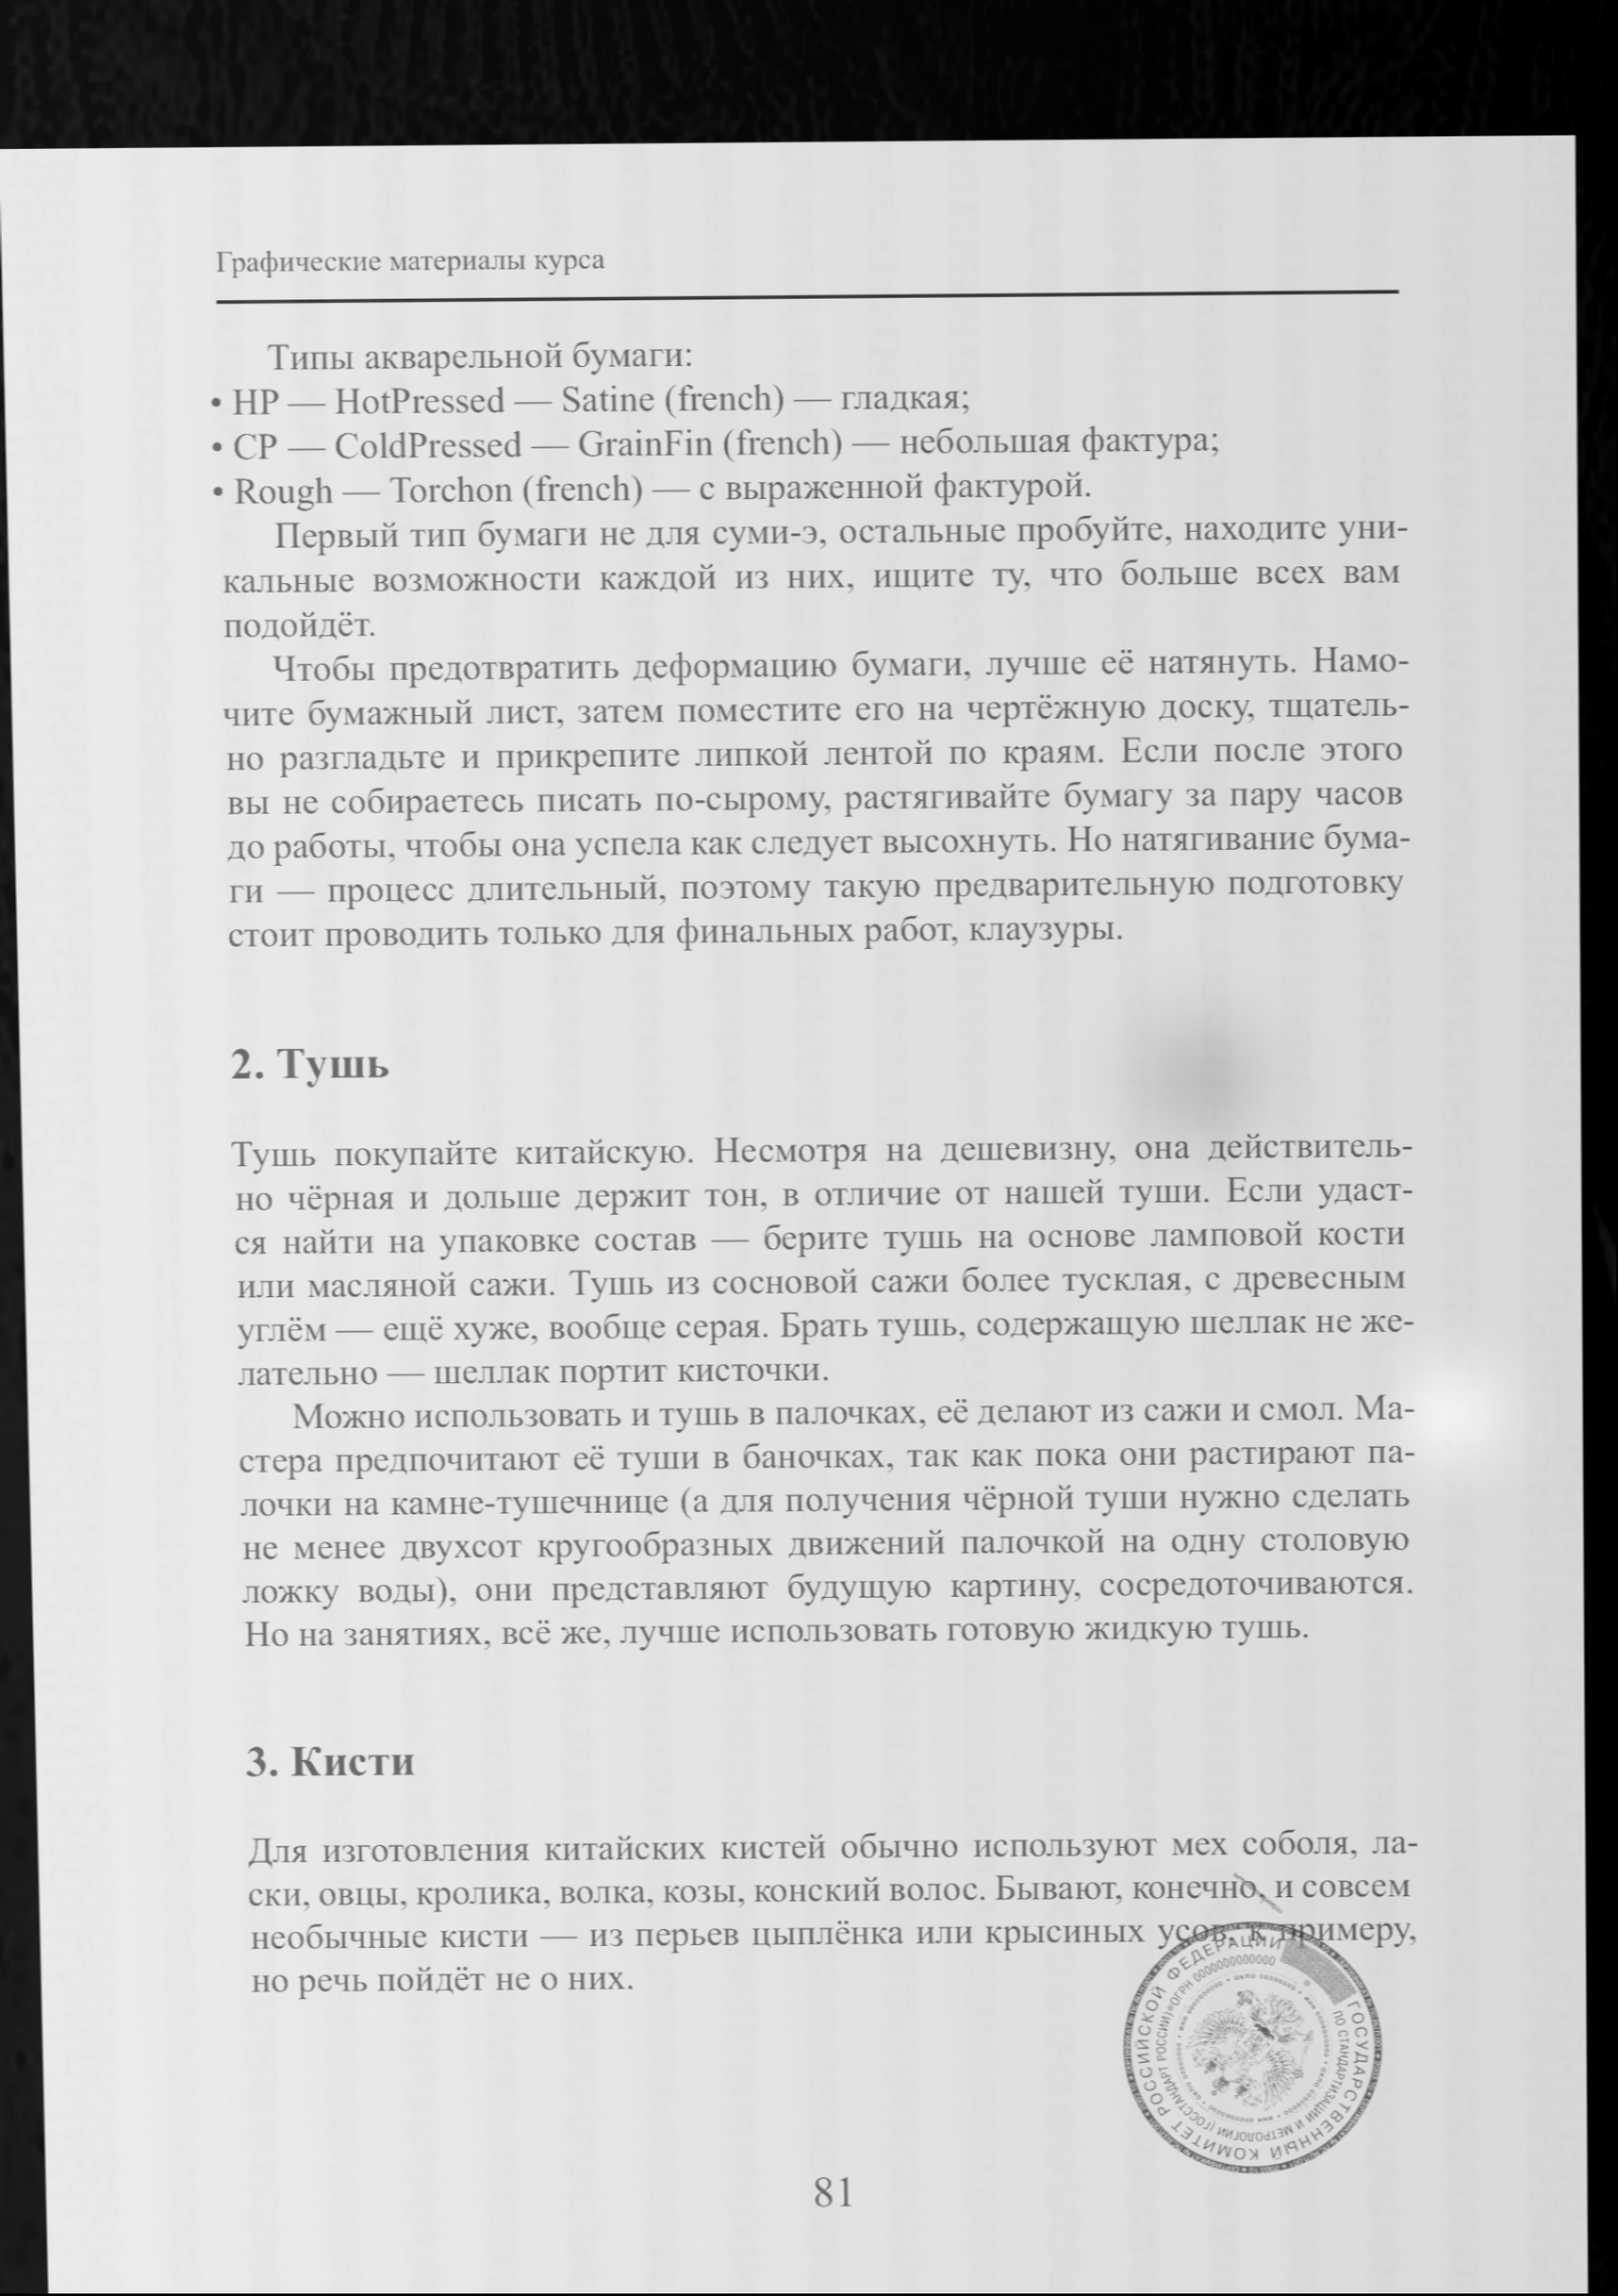

In [ ]:
def recover_image(sliced_images, image_size, n_images):
  """
  Recover image from tf.image.extract_patches. 
  sliced_images - tf.constant with shape - [n_images, height, width, 1]
  image_size - tuple (height,width) original image size (before slicing)
  n_images - tuple (horizontal, vertical) number of patches 
  """
  # Drop single color channel
  sliced_images = tf.squeeze(sliced_images)
  kernel_size = sliced_images.shape[1:3]
  steps = [(image_size[i] - kernel_size[i]) // (n_images[i] - 1) for i in range(2)]
  # Initialize image
  recovered = tf.zeros(image_size)
  mask = tf.zeros(image_size, dtype=tf.int8)
  # Kernel for counting overlaps
  kernel_ones = tf.ones(kernel_size,dtype=tf.int8)
  counter = 0
  for j in range(n_images[0]):
    for i in range(n_images[1]):
      # Make indices from meshgrid
      indexes = tf.meshgrid(tf.range(steps[0] * j, # row start
                                    kernel_size[0] + steps[0] * j), # row end
                            tf.range(steps[1] * i, # col_start
                                    kernel_size[1] + steps[1] * i), indexing='ij') # col_end
      indexes = tf.stack(indexes, axis=-1)
      # Add sliced image to recovered image indice
      recovered = tf.tensor_scatter_nd_add(recovered, indexes, sliced_images[counter])
      # Update mask
      mask = tf.tensor_scatter_nd_add(mask, indexes, kernel_ones)
      counter += 1
  recovered = recovered / tf.cast(mask, tf.float32)
  return recovered


img = recover_image((ex + 1) * 127.5, 
                    image_size=(2729, 1923), 
                    n_images=(8,6))
cv2_imshow(img.numpy())

### All boxes on recovered image

In [ ]:
boxes = bboxes

boxes = (boxes * [1923, 2729, 1923, 2729]).astype(int)

boxes = [np.array([[box[0], box[1]], [box[2], box[1]], [box[2], box[3]], [box[0], box[3]]]) for box in boxes]
# xmin ymin xmax ymax

box_image = cv2.polylines(img.numpy(), boxes, True, (0, 0, 0), 2) 
cv2_imshow(box_image)

## Visualize unprocessed sliced box
Before processing into YOLOv3 expected format

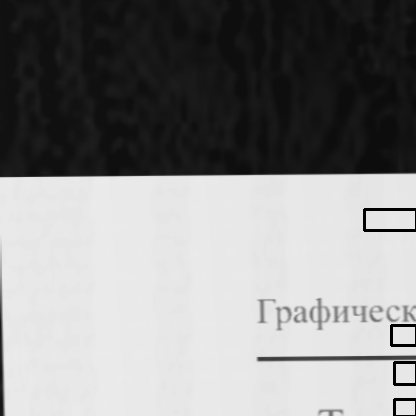

In [ ]:
def show_unprocessed_sliced_boxes(image, boxes):
  """
  Args:
  Image: image from dataset (tensor)
  Boxes: (xmin, ymin, xmax, ymax) (numpy)
  """
  full_box = boxes[np.all(boxes != 0, axis=1)]

  boxes = (full_box * 416).astype(int)
  boxes = [np.array([[box[0], box[1]], [box[2], box[1]], [box[2], box[3]], [box[0], box[3]]]) for box in boxes]
  # xmin ymin xmax ymax
  import cv2

  pts = np.array([[300, 300],
                  [340, 300],
                  [340,340],
                  [300, 340]],
                np.int32)
  pts = pts.reshape((-1, 1, 2)) 

  box_image = cv2.polylines((image.numpy().squeeze() + 1) * 127.5, boxes, True, (0, 0, 0), 2) 
  cv2_imshow(box_image)


image_n = 0
boxes = label[3][image_n].numpy()
image = ex[image_n]

show_unprocessed_sliced_boxes(image, boxes)

## Visualize postprocessed sliced box
Note - import posprocessor class (lower)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
x, y_true = ex, label
class_names = {0:"Text", 1:"Empty"}

In [ ]:
# Untupling label
y_true_f = []
for i in range(3):
  box_true = y_true[i][:,:,:,:,0:4]
  confidence = y_true[i][:,:,:,:,4]
  classes1 = y_true[i][:,:,:,:,5:7]
  y_true_f.append((box_true, confidence, classes1))

postprocess = Postprocessor(iou_thresh=0.5, score_thresh=0.5)
y_pred_nms = postprocess(y_true_f)

In [ ]:
n_image = 5
num_predictions = y_pred_nms[3][n_image][0].numpy()
print('Number of predictions: ', num_predictions)

Number of predictions:  6


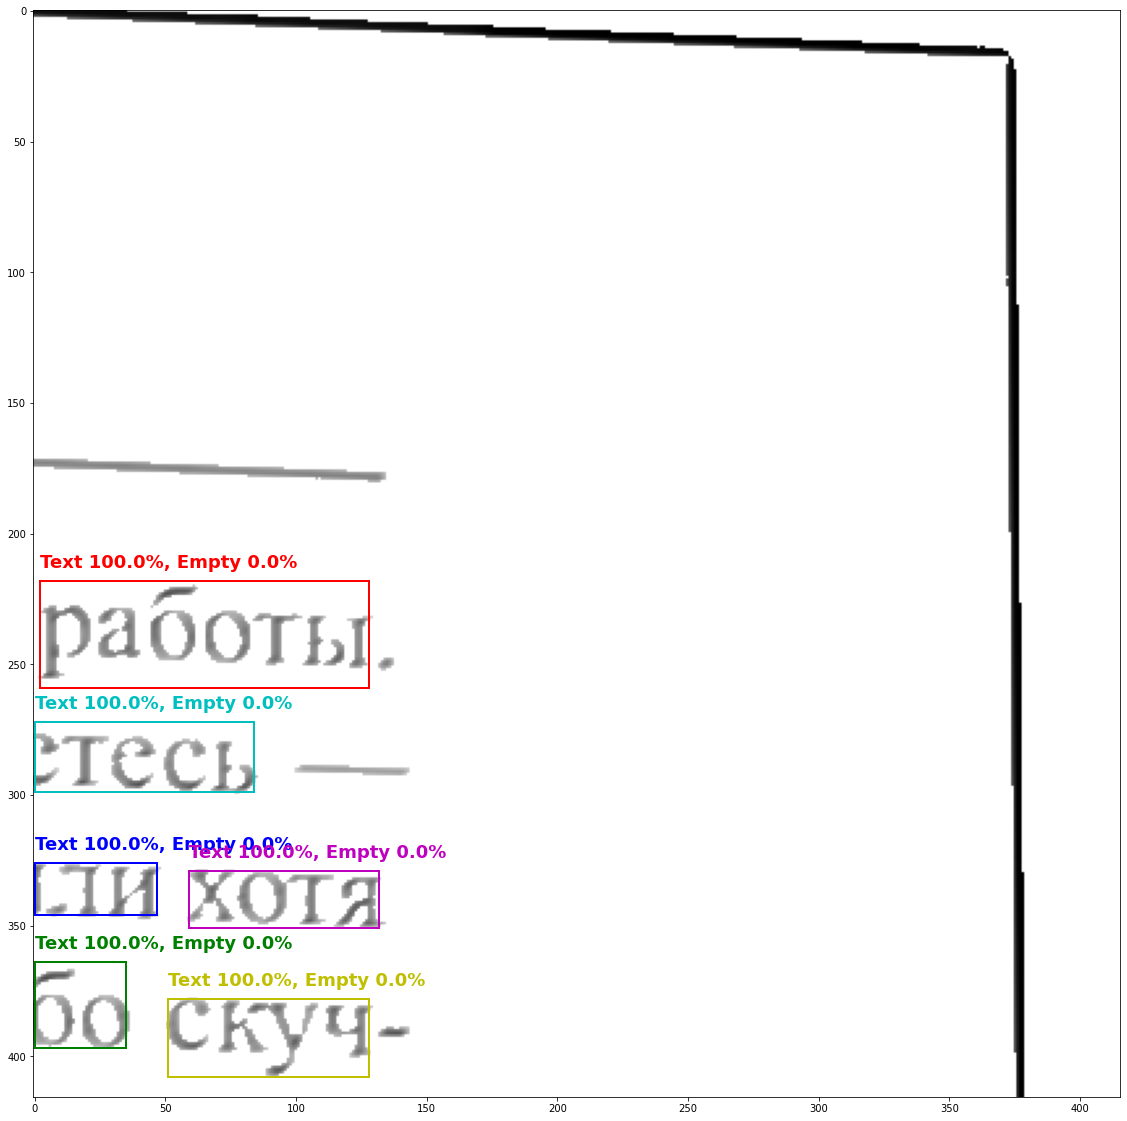

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
im = tf.cast((x[n_image] + 1) * 127.5, tf.int32)

plt.rcParams['figure.figsize'] = (20,20)
fig,ax = plt.subplots(1)
ax.imshow(im.numpy().squeeze(), cmap="gray")
h, w, d = im.shape

for i in range(0, num_predictions):
    box = y_pred_nms[0][n_image][i].numpy()
    score = y_pred_nms[1][n_image][i][0].numpy()
    class_prob = y_pred_nms[2][n_image][i].numpy()
    values, indices = tf.math.top_k(class_prob, k=2)
    text= []
    for index, prob in zip(indices.numpy(), values.numpy()):
        text.append('{} {:.1f}%'.format(class_names[index], prob*100))
    text = ', '.join(text)
    xmin = box[0] * w
    ymin = box[1] * h
    width = (box[2] - box[0]) * w
    height = (box[3] - box[1]) * h
    color = colors[i % 8]
    rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
    ax.annotate(text, (xmin, ymin - 5), color=color, weight='bold', 
                fontsize=18)

plt.show()

# Training class

In [ ]:
BATCH_SIZE = 16
TOTAL_CLASSES = 2
TOTAL_EPOCHS = 20
OUTPUT_SHAPE = (416, 416)
PROJECT_FOLDER = '/content/drive/My Drive/DocumentProcessing/YoloV3/'

tf.random.set_seed(1)


class Trainer(object):
    def __init__(self,
                 model,
                 initial_epoch,
                 epochs,
                 batch_size,
                 initial_learning_rate=0.01):
        self.model = model
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        #self.strategy = strategy
        self.global_batch_size = batch_size
        self.loss_objects = [
            YoloLoss(
                num_classes=TOTAL_CLASSES,
                valid_anchors_wh=anchors_wh[0:3]),  # small scale 52x52
            YoloLoss(
                num_classes=TOTAL_CLASSES,
                valid_anchors_wh=anchors_wh[3:6]),  # medium scale 26x26
            YoloLoss(
                num_classes=TOTAL_CLASSES,
                valid_anchors_wh=anchors_wh[6:9]),  # large scale 13x13
        ]
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)

        # for learning rate schedule
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 3

    def lr_decay(self):
        """
        This effectively simulate ReduceOnPlateau learning rate schedule. Learning rate
        will be reduced by a factor of 10 if there's no improvement over [max_patience] epochs
        """
        if self.patience_count > self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def train_step(self, inputs):
        images, labels = inputs

        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            total_losses = []
            xy_losses = []
            wh_losses = []
            class_losses = []
            obj_losses = []
            # iterate over all three scales
            for loss_object, y_pred, y_true in zip(self.loss_objects, outputs,
                                                   labels):
                total_loss, loss_breakdown = loss_object(y_true, y_pred)
                xy_loss, wh_loss, class_loss, obj_loss = loss_breakdown
                total_losses.append(total_loss * (1. / self.global_batch_size))
                xy_losses.append(xy_loss * (1. / self.global_batch_size))
                wh_losses.append(wh_loss * (1. / self.global_batch_size))
                class_losses.append(class_loss * (1. / self.global_batch_size))
                obj_losses.append(obj_loss * (1. / self.global_batch_size))

            total_loss = tf.reduce_sum(total_losses)
            total_xy_loss = tf.reduce_sum(xy_losses)
            total_wh_loss = tf.reduce_sum(wh_losses)
            total_class_loss = tf.reduce_sum(class_losses)
            total_obj_loss = tf.reduce_sum(obj_losses)

        grads = tape.gradient(
            target=total_loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return total_loss, (total_xy_loss, total_wh_loss, total_class_loss,
                            total_obj_loss)

    def val_step(self, inputs):
        images, labels = inputs

        outputs = self.model(images, training=False)
        losses = []
        # iterate over all three scales
        for loss_object, y_pred, y_true in zip(self.loss_objects, outputs,
                                               labels):
            loss, _ = loss_object(y_true, y_pred)
            losses.append(loss * (1. / self.global_batch_size))
        total_loss = tf.reduce_sum(losses)

        return total_loss

    def get_current_time(self):
        return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    def run(self, train_dataset, val_dataset):
        total_steps = tf.constant(0, dtype=tf.int64)

        @tf.function
        def train_epoch(dataset, train_summary_writer,
                                    total_steps):
            total_loss = 0.0
            num_train_batches = tf.constant(0, dtype=tf.int64)
       
            for one_batch in dataset:
              batch_loss, per_replica_losses_breakdown = self.train_step(one_batch)
              batch_xy_loss, batch_wh_loss, batch_class_loss, batch_obj_loss = per_replica_losses_breakdown

              total_loss += batch_loss
              num_train_batches += 1
              if num_train_batches % 100 == 0: 
                tf.print('Trained batch:', num_train_batches, 'batch loss:',
                          batch_loss, 'batch xy loss', batch_xy_loss,
                          'batch wh loss', batch_wh_loss, 'batch obj loss',
                          batch_obj_loss, 'batch_class_loss', batch_class_loss,
                          'epoch total loss:', total_loss)
              with train_summary_writer.as_default():
                  tf.summary.scalar(
                      'batch train loss',
                      batch_loss,
                      step=total_steps + num_train_batches)
                  tf.summary.scalar(
                      'batch xy loss',
                      batch_xy_loss,
                      step=total_steps + num_train_batches)
                  tf.summary.scalar(
                      'batch wh loss',
                      batch_wh_loss,
                      step=total_steps + num_train_batches)
                  tf.summary.scalar(
                      'batch obj loss',
                      batch_obj_loss,
                      step=total_steps + num_train_batches)
                  tf.summary.scalar(
                      'batch class loss',
                      batch_class_loss,
                      step=total_steps + num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = tf.constant(0, dtype=tf.int64)
            for one_batch in dataset:
              batch_loss = self.val_step(one_batch)
              total_loss += batch_loss
              num_val_batches += 1
            return total_loss, num_val_batches

        current_time = self.get_current_time()
        train_log_dir = PROJECT_FOLDER + 'logs/gradient_tape/' + current_time + '/train'
        val_log_dir = PROJECT_FOLDER + 'logs/gradient_tape/' + current_time + '/val'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        val_summary_writer = tf.summary.create_file_writer(val_log_dir)

        tf.print('{} Start training...'.format(current_time))
        for epoch in range(self.initial_epoch, self.epochs + 1):
            t0 = time.time()
            self.lr_decay()

            tf.print(
                '{} Started epoch {} with learning rate {}. Current LR patience count is {} epochs. Last lowest val loss is {}.'
                .format(self.get_current_time(), epoch,
                        self.current_learning_rate, self.patience_count,
                        self.lowest_val_loss))

            train_total_loss, num_train_batches = train_epoch(
                train_dataset, train_summary_writer, total_steps)
            t1 = time.time()
            train_loss = train_total_loss / tf.cast(
                num_train_batches, dtype=tf.float32)
            
            tf.print(
                '{} Epoch {} train loss {}, total train batches {}, {} examples per second'
                .format(
                    self.get_current_time(), epoch, train_loss,
                    num_train_batches,
                    tf.cast(num_train_batches, dtype=tf.float32) *
                    self.global_batch_size / (t1 - t0)))
            with train_summary_writer.as_default():
                tf.summary.scalar('epoch train loss', train_loss, step=epoch)
            total_steps += num_train_batches

            val_total_loss, num_val_batches = val_epoch(
                val_dataset)

            t2 = time.time()
            val_loss = val_total_loss / tf.cast(
                num_val_batches, dtype=tf.float32)
            tf.print(
                '{} Epoch {} val loss {}, total val batches {}, {} examples per second'
                .format(
                    self.get_current_time(), epoch, val_loss, num_val_batches,
                    tf.cast(num_val_batches, dtype=tf.float32) *
                    self.global_batch_size / (t2 - t1)))
            with val_summary_writer.as_default():
                tf.summary.scalar('epoch val loss', val_loss, step=epoch)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
              #  self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

            # save model after epoch
            print("saving model after {} epoch".format(epoch))
            self.save_model(epoch, val_loss)
  
        self.save_model(self.epochs, self.last_val_loss)
        print('{} Finished.'.format(self.get_current_time()))

    def save_model(self, epoch, loss):
        # https://github.com/tensorflow/tensorflow/issues/33565
        model_name = PROJECT_FOLDER + 'models/model-v1.0.1-epoch-{}-loss-{:.4f}.tf'.format(
            epoch, loss)
        self.model.save_weights(model_name)
        print("Model {} saved.".format(model_name))


def create_dataset(tfrecords, batch_size, is_train):
    preprocess = Preprocessor(is_train, TOTAL_CLASSES, OUTPUT_SHAPE)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(preprocess).unbatch()
    
    tupling_label = lambda x,y1,y2,y3: (x, (y1,y2,y3))
    dataset = dataset.map(tupling_label)
    #if is_train:
    #    dataset = dataset.shuffle(512)


    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

# Training

In [ ]:
TF_RECORDS = PROJECT_FOLDER + 'tfrecords_voc'
#TF_RECORDS = PROJECT_FOLDER + 'tfrec_samp'
 
train_dataset = create_dataset(
    '{}/train*'.format(TF_RECORDS), BATCH_SIZE, is_train=True)
 
val_dataset = create_dataset(
    '{}/val*'.format(TF_RECORDS), BATCH_SIZE, is_train=False)

In [ ]:
model = YoloV3(
    shape=(416, 416, 1), num_classes=TOTAL_CLASSES, training=True)
#model.summary()
initial_epoch = 1
 
trainer = Trainer(
  model=model,
  initial_epoch=initial_epoch,
  epochs=TOTAL_EPOCHS,
  batch_size=BATCH_SIZE
)
 
trainer.run(train_dataset, val_dataset)

20200914-145446 Start training...
20200914-145447 Started epoch 1 with learning rate 0.01. Current LR patience count is 1 epochs. Last lowest val loss is inf.
Trained batch: 100 batch loss: 173.775177 batch xy loss 23.6423359 batch wh loss 72.8446579 batch obj loss 76.5578537 batch_class_loss 0.73031646 epoch total loss: 82302.8906
Trained batch: 200 batch loss: 48.041729 batch xy loss 7.93860435 batch wh loss 5.7083559 batch obj loss 32.7976379 batch_class_loss 1.59713364 epoch total loss: 108744.219
Trained batch: 300 batch loss: 27.5659103 batch xy loss 4.04532623 batch wh loss 8.12394 batch obj loss 15.078496 batch_class_loss 0.318146795 epoch total loss: 126230.68
Trained batch: 400 batch loss: 23.9566193 batch xy loss 2.41585255 batch wh loss 5.99150085 batch obj loss 15.107666 batch_class_loss 0.441601962 epoch total loss: 134789.344
Trained batch: 500 batch loss: 376.958984 batch xy loss 39.2821465 batch wh loss 227.143219 batch obj loss 110.122688 batch_class_loss 0.410916179 

# Postprocessor class

In [ ]:
class Postprocessor(object):
    def __init__(self, iou_thresh, score_thresh, max_detection=100):
        self.iou_thresh = iou_thresh
        self.score_thresh = score_thresh
        self.max_detection = max_detection

    def __call__(self, raw_yolo_outputs):
        boxes, objectness, class_probs = [], [], []

        for o in raw_yolo_outputs:
            batch_size = tf.shape(o[0])[0]
            num_classes = tf.shape(o[2])[-1]
            # needs to translate from xywh to y1x1y2x2 format
            boxes.append(tf.reshape(o[0], (batch_size, -1, 4)))
            objectness.append(tf.reshape(o[1], (batch_size, -1, 1)))
            class_probs.append(tf.reshape(o[2], (batch_size, -1, num_classes)))

        boxes = xywh_to_x1x2y1y2(tf.concat(boxes, axis=1))

        objectness = tf.concat(objectness, axis=1)
        class_probs = tf.concat(class_probs, axis=1)

        scores = objectness
        scores = tf.reshape(scores,
                            (tf.shape(scores)[0], -1, tf.shape(scores)[-1]))

        final_boxes, final_scores, final_classes, valid_detections = self.batch_non_maximum_suppression(
            boxes, scores, class_probs, self.iou_thresh, self.score_thresh,
            self.max_detection)

        return final_boxes, final_scores, final_classes, valid_detections, scores
        #return boxes, scores, class_probs 

    
    @staticmethod
    def batch_non_maximum_suppression(boxes, scores, classes, iou_threshold,
                                      score_threshold, max_detection, *args):
        """
        Unlike tf.image.combined_non_max_suppression, we are making multi-label classification on the detection
        """

        def single_batch_nms(candidate_boxes):
            # filter out predictions with score less than score_threshold
            candidate_boxes = tf.boolean_mask(
                candidate_boxes, candidate_boxes[..., 4] >= score_threshold)
            outputs = tf.zeros((max_detection + 1,
                                tf.shape(candidate_boxes)[-1]))
            indices = []
            updates = []

            count = 0
            # keep running this until there's no more candidate box or max_detection is met
  
            while tf.shape(candidate_boxes)[0] > 0 and count < max_detection:
                #tf.autograph.experimental.set_loop_options(candidate_boxes, tf.TensorShape([None]))

                # pick the box with the highest score
                best_idx = tf.math.argmax(candidate_boxes[..., 4], axis=0)
                best_box = candidate_boxes[best_idx]
                # add this best box to the output
                indices.append([count])
                updates.append(best_box)
                count += 1
                # remove this box from candidate boxes
                candidate_boxes = tf.concat([
                    candidate_boxes[0:best_idx],
                    candidate_boxes[best_idx + 1:tf.shape(candidate_boxes)[0]]
                ],
                                            axis=0)
                # calculate IOU between this box and all remaining candidate boxes
                iou = broadcast_iou(best_box[0:4], candidate_boxes[..., 0:4])
                # remove all candidate boxes with IOU bigger than iou_threshold
                candidate_boxes = tf.boolean_mask(candidate_boxes,
                                                  iou[0] <= iou_threshold)
            if count > 0:
                # also append num_detection to the result
                count_index = [[max_detection]]
                count_updates = [
                    tf.fill([tf.shape(candidate_boxes)[-1]], count)
                ]
                indices = tf.concat([indices, count_index], axis=0)
                updates = tf.concat([updates, count_updates], axis=0)
                outputs = tf.tensor_scatter_nd_update(outputs, indices,
                                                      updates)
            return outputs

        combined_boxes = tf.concat([boxes, scores, classes], axis=2)
        
        single_batch_nms = tf.autograph.experimental.do_not_convert(single_batch_nms)
        result = tf.map_fn(single_batch_nms, combined_boxes)

        # take out num_detection from the result
        func1 = lambda x: x[max_detection][0]
        func2 = lambda x: x[0:max_detection]
        valid_counts = tf.expand_dims(
            tf.map_fn(func1, result), axis=-1)
        final_result = tf.map_fn(func2, result)
        nms_boxes, nms_scores, nms_classes = tf.split(
            final_result, [4, 1, -1], axis=-1)
        return nms_boxes, nms_scores, nms_classes, tf.cast(
            valid_counts, tf.int32)

# Visalization of predictions

## Data postprocessing

In [ ]:
TOTAL_CLASSES = 2

model = YoloV3(shape=(416, 416, 1), num_classes=TOTAL_CLASSES, training=False) 
model.load_weights(PROJECT_FOLDER + 'models/model-v1.0.1-epoch-10-loss-12.1738.tf')

In [ ]:
preprocess = Preprocessor(False, TOTAL_CLASSES, (416, 416))

# Takes single test image and then cuts it in 48 pieces.
test_set = tf.data.Dataset.list_files(PROJECT_FOLDER + 'tfrecords_voc' + '/test_0002.tfrecords')
test_set = tf.data.TFRecordDataset(test_set)
test_set = test_set.map(preprocess).unbatch()

tupling_label = lambda x,y1,y2,y3: (x, (y1,y2,y3))
test_set  = test_set.map(tupling_label)
test_set = test_set.batch(16)
x, y_true = next(iter(test_set))

class_names = {0:"Text", 1:"Empty"}

In [ ]:
# Play with score_thresh parameter for better results
postprocess = Postprocessor(iou_thresh=0.5, score_thresh=0.15)
y_pred = model(x, training=False)
y_pred_nms = postprocess(y_pred)

n = 14 # image in batch
num_predictions = y_pred_nms[3][n][0].numpy()
print('Number of predictions: ', num_predictions)

Number of predictions:  25


### Same for original label (input)

In [ ]:
y_true_f = []
for i in range(3):
  box_true = y_true[i][:,:,:,:,0:4]
  confidence = y_true[i][:,:,:,:,4]
  classes1 = y_true[i][:,:,:,:,5:7]
  y_true_f.append((box_true, confidence, classes1))

In [ ]:
postprocess = Postprocessor(iou_thresh=0.5, score_thresh=0.5)
y_pred_nms = postprocess(y_true_f)

n = 9 # image in batch
num_predictions = y_pred_nms[3][n][0].numpy()
print('Number of predictions: ', num_predictions)

Numcl tf.Tensor(2, shape=(), dtype=int32)
Numcl tf.Tensor(2, shape=(), dtype=int32)
Numcl tf.Tensor(2, shape=(), dtype=int32)


## Visualize

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

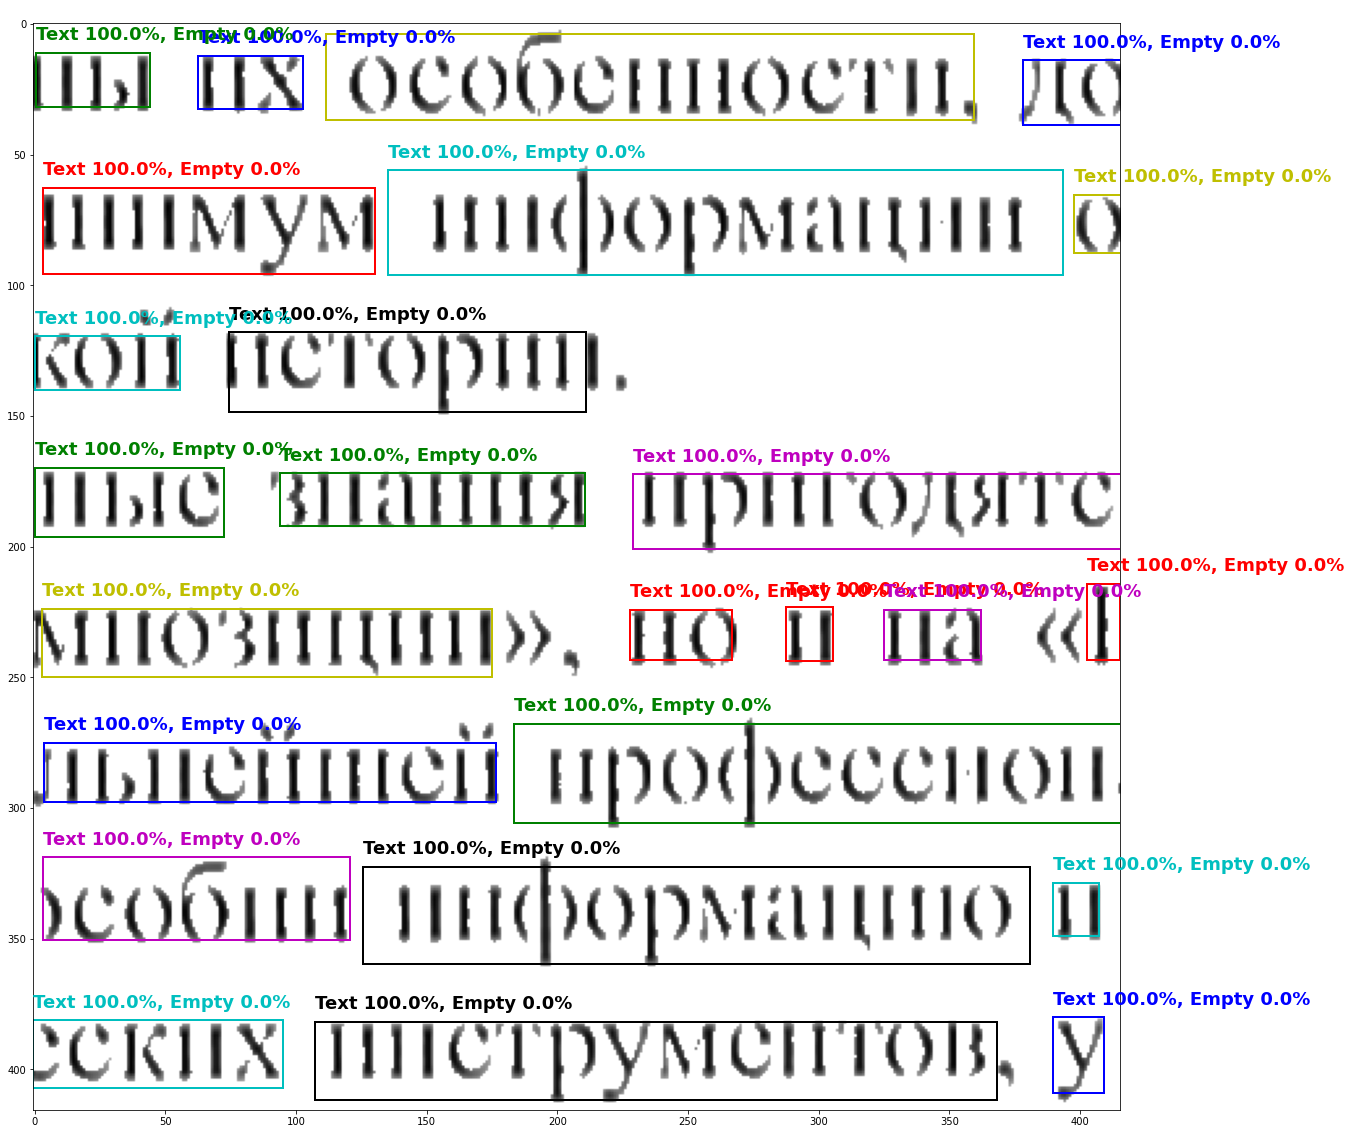

In [ ]:
n = 14 # image in batch

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
im = tf.cast((x[n] + 1) * 127.5, tf.int32)

plt.rcParams['figure.figsize'] = (20,20)
fig,ax = plt.subplots(1)
ax.imshow(im.numpy().squeeze(), cmap="gray")
h, w, d = im.shape

for i in range(0, num_predictions):
    box = y_pred_nms[0][n][i].numpy()
    score = y_pred_nms[1][n][i][0].numpy()
    class_prob = y_pred_nms[2][n][i].numpy()
    values, indices = tf.math.top_k(class_prob, k=2)
    text= []
    for index, prob in zip(indices.numpy(), values.numpy()):
        text.append('{} {:.1f}%'.format(class_names[index], prob*100))
    text = ', '.join(text)
    xmin = box[0] * w
    ymin = box[1] * h
    width = (box[2] - box[0]) * w
    height = (box[3] - box[1]) * h
    color = colors[i % 7]
    rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
    ax.annotate(text, (xmin, ymin - 5), color=color, weight='bold', 
                fontsize=18)

plt.show()

# Conclusions

YoloV3 handled this relatively simple task (for such robust model) of text detection really well. 
Model training speed was ok, but the main bottleneck was data procession, especially loading and cutting images.

Next tasks: 

* Recover cut images with predicted labels.

* Simplify and specify the model for current task.

* Start working on OCR part